In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import sys

import pandas as pd
import catboost as cb
import xgboost as xgb
import imblearn
import lightgbm as lgb
import numpy as np
import seaborn as sns

# https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html#sphx-glr-auto-examples-impute-plot-iterative-imputer-variants-comparison-py
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

wids_path = "/Users/diana/Documents/projects/widsdatathon2022"
sys.path.append(wids_path)

from global_vars import (
    all_feature_columns,
    response_column,
    facility_type_dict,
    refridgerated_bool_dict,
    temp_col_list,
    days_col_list,
    inch_col_list,
    wind_col_list,
)
import utils.model_utils as mu
from utils.data_utils import *
import utils.visualize as viz
from utils.data_process_utils import *


sys.path.append("kuma_utils/")
from kuma_utils.preprocessing.imputer import LGBMImputer

pd.set_option("display.max_columns", 500)
sns.set_context("talk")

#### read in data
test_df = pd.read_csv(f"{wids_path}/data/test.csv")
print(f"Test dimension: {test_df.shape}")
train_df = pd.read_csv(f"{wids_path}/data/train.csv")
print(f"Train dimension: {train_df.shape}")
sample_solution_df = pd.read_csv(f"{wids_path}/data/sample_solution.csv")
print(f"Sample solution dimension: {sample_solution_df.shape}")
train_df.columns = train_df.columns.str.lower()
test_df.columns = test_df.columns.str.lower()

/Users/diana/anaconda/envs/py37/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Test dimension: (9705, 63)
Train dimension: (75757, 64)
Sample solution dimension: (9705, 2)


<IPython.core.display.Javascript object>

In [3]:
facility_type_dict = {
    "2to4_unit_building": "unit_building",
    "5plus_unit_building": "unit_building",
    "commercial_other": "commercial",
    "commercial_unknown": "commercial",
    "data_center": "data",
    "education_college_or_university": "education",
    "education_other_classroom": "education",
    "education_preschool_or_daycare": "education",
    "education_uncategorized": "education",
    "food_sales": "food",
    "food_service_other": "food",
    "food_service_restaurant_or_cafeteria": "food",
    "food_service_uncategorized": "food",
    "grocery_store_or_food_market": "grocery",
    "health_care_inpatient": "health",
    "health_care_outpatient_clinic": "health",
    "health_care_outpatient_uncategorized": "health",
    "health_care_uncategorized": "health",
    "industrial": "industrial",
    "laboratory": "laboratory",
    "lodging_dormitory_or_fraternity_sorority": "lodging",
    "lodging_hotel": "lodging",
    "lodging_other": "lodging",
    "lodging_uncategorized": "lodging",
    "mixed_use_commercial_and_residential": "commercial",
    "mixed_use_predominantly_commercial": "commercial",
    "mixed_use_predominantly_residential": "lodging",
    "multifamily_uncategorized": "lodging",
    "nursing_home": "health",
    "office_bank_or_other_financial": "office",
    "office_medical_non_diagnostic": "office",
    "office_mixed_use": "office",
    "office_uncategorized": "office",
    "parking_garage": "parking",
    "public_assembly_drama_theater": "public",
    "public_assembly_entertainment_culture": "public",
    "public_assembly_library": "public",
    "public_assembly_movie_theater": "public",
    "public_assembly_other": "public",
    "public_assembly_recreation": "public",
    "public_assembly_social_meeting": "public",
    "public_assembly_stadium": "public",
    "public_assembly_uncategorized": "public",
    "public_safety_courthouse": "public",
    "public_safety_fire_or_police_station": "public",
    "public_safety_penitentiary": "public",
    "public_safety_uncategorized": "public",
    "religious_worship": "religious",
    "retail_enclosed_mall": "retail",
    "retail_strip_shopping_mall": "retail",
    "retail_uncategorized": "retail",
    "retail_vehicle_dealership_showroom": "retail",
    "service_drycleaning_or_laundry": "laundry",
    "service_uncategorized": "service",
    "service_vehicle_service_repair_shop": "service",
    "warehouse_distribution_or_shipping_center": "warehouse",
    "warehouse_nonrefrigerated": "warehouse",
    "warehouse_refrigerated": "warehouse",
    "warehouse_selfstorage": "warehouse",
    "warehouse_uncategorized": "warehouse",
}

refridgerated_bool_dict = {
    "data_center": True,
    "food_service_restaurant_or_cafeteria": True,
    "food_sales": True,
    "grocery_store_or_food_market": True,
    "health_care_inpatient": True,
    "laboratory": True,
}

<IPython.core.display.Javascript object>

In [4]:
## Feature cleaning/engineering configs
cols_to_drop = [
    "days_with_fog",
    "direction_max_wind_speed",
    "direction_peak_wind_speed",
    "max_wind_speed",
    "facility_type",
]
base_dict = {
    "cols_to_reduce": [],
    "log10_transform_cols": [],
    "if_one_hot": False,
    "backfill_dict": {},
    "resample_param_dict": {},
    "categorical_features_to_reduce": None,
    "model": None,
    "impute_model": None,
    "validation_strategy": mu.run_leave_year_out,
}

update_dict = {
    "cat": {"if_one_hot": False},
    "onehot": {"if_one_hot": True},
    "log": {"log10_transform_cols": ["floor_area", "elevation"]},
    "temppca": {"cols_to_reduce": temp_col_list},
    "allenvpca": {
        "cols_to_reduce": list(
            set(temp_col_list + days_col_list + inch_col_list + wind_col_list)
            - set(cols_to_drop)
        )
    },
    "impute": {
        "backfill_dict": {
            "energy_star_rating": ["state_factor", "building_class", "facility_type",]
        }
    },
    "upsamplecustom": {
        "resample_param_dict": {
            "up_or_downsample": "custom_upsample",
            "resample_by_col": "state_factor",
            "resample_type": "",
        }
    },
    "upsamplesmote": {
        "resample_param_dict": {
            "up_or_downsample": "upsample",
            "resample_by_col": "state_factor",
            "resample_type": "smote",
        }
    },
    "upsample": {
        "resample_param_dict": {
            "up_or_downsample": "upsample",
            "resample_by_col": "state_factor",
            "resample_type": "random",
        }
    },
    "parse": {"categorical_feature_to_reduce": "facility_type"},
    "parse2": {"categorical_feature_to_reduce": "facility_type"},
    "cooled": {},
    "catboost": {"model": "catboost"},
    "xgboost": {"model": "xgboost"},
    "lightgbm": {"model": "lightgbm"},
    "dnn": {"model": "dnn"},
    "knnimpute": {
        "impute_model": IterativeImputer(
            random_state=0, estimator=KNeighborsRegressor(n_neighbors=15)
        )
    },
    "missforestimpute": {
        "impute_model": IterativeImputer(
            random_state=0,
            estimator=ExtraTreesRegressor(n_estimators=10, random_state=0),
        )
    },
    "lgbmimpute": {"impute_model": LGBMImputer(n_iter=100, verbose=True)},
    "stratified": {"validation_strategy": mu.run_bootstrap_stratified_validation},
    "base": base_dict.copy(),
}


<IPython.core.display.Javascript object>

In [5]:
## Model configs
seed = 0
depth = 12

model_dict = {
    "catboost": cb.CatBoostRegressor(
        loss_function="RMSE",
        depth=depth,
        random_seed=seed,
        verbose=False,
        nan_mode="Min",
    ),
    "xgboost": xgb.XGBRegressor(
        eval_metric="rmse",
        seed=seed,
        max_depth=depth,
        n_estimators=1000,
        booster="gbtree",
        n_jobs=-1,
        num_leaves=15,
        subsample=0.9,
        colsample_bytree=0.7,
        random_state=seed,
        learning_rate=0.05,
    ),
    "lightgbm": lgb.LGBMRegressor(
        n_estimators=30000,
        max_depth=depth,
        num_leaves=15,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.7,
        random_state=seed,
    ),
    "dnn": None,
}

model_type_dict = {
    "catboost": "catboost",
    "xgboost": "sklearn",
    "lightgbm": "lightgbm",
    "dnn": "dnn",
}

# Define which function to run
run_model_dict = {
    "sklearn": mu.run_sklearn_model,
    "catboost": mu.run_catboost_model,
    "lightgbm": mu.run_lgb_model,
    "dnn": mu.run_dnn_model,
}

<IPython.core.display.Javascript object>

In [6]:
config_list = [
    #     "log_onehot_temppca_parse_upsample_impute_dnn",
    #     "log_onehot_temppca_parse_upsample_impute_catboost",
    #     "log_onehot_temppca_parse_upsample_impute_lightgbm",
    #     "log_onehot_allenvpca_parse_upsample_impute_dnn",
    #     "log_onehot_allenvpca_parse_upsample_impute_catboost",
    #     "log_onehot_allenvpca_parse_upsample_impute_lightgbm",
    #     "log_onehot_allenvpca_parse_upsample_catboost",
    #     "log_onehot_allenvpca_parse_upsample_lightgbm",
    #     "log_onehot_temppca_parse_upsample_catboost",
    #     "log_onehot_allenvpca_parse_missforestimpute_cooled_catboost"
]


<IPython.core.display.Javascript object>

Fitting PCA with 9 components
log_onehot_temppca_parse_stratified_catboost ['snowfall_inches', 'days_below_20f', 'heating_degree_days', 'days_above_80f', 'year_built', 'days_above_100f', 'building_class', 'precipitation_inches', 'state_factor', 'snowdepth_inches', 'cooling_degree_days', 'days_below_30f', 'days_above_90f', 'days_below_10f', 'energy_star_rating', 'days_below_0f', 'days_above_110f', 'temp_pca1', 'temp_pca2', 'temp_pca3', 'temp_pca4', 'temp_pca5', 'temp_pca6', 'temp_pca7', 'temp_pca8', 'temp_pca9', 'log10_floor_area', 'log10_elevation', 'facility_type_parsed', 'year_factor'] True
Starting bootstrap 0
Running catboost
Modeling strat 0
Modeling strat 1
Modeling strat 2
Modeling strat 3
Modeling strat 4
<class 'pandas.core.frame.DataFrame'>    stratification  train_rmse  test_rmse
0               0   29.260653  46.902248
1               1   27.791384  51.939942
2               2   27.994753  49.167075
3               3   29.723889  42.764175
4               4   29.983715  47.

,stratification,train_rmse,test_rmse,bootstrap,method
0,0.0,29.260653,46.902248,0.0,bootstrat
1,1.0,27.791384,51.939942,0.0,bootstrat
2,2.0,27.994753,49.167075,0.0,bootstrat
3,3.0,29.723889,42.764175,0.0,bootstrat
4,4.0,29.983715,47.478747,0.0,bootstrat
0,0.0,29.446742,46.926692,1.0,bootstrat
1,1.0,28.221138,51.574558,1.0,bootstrat
2,2.0,27.922769,49.580860,1.0,bootstrat
3,3.0,29.620707,42.759087,1.0,bootstrat
4,4.0,29.562399,47.658238,1.0,bootstrat


/Users/diana/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


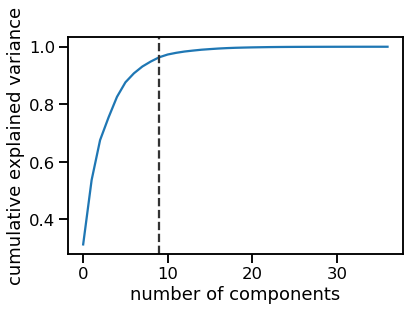

<IPython.core.display.Javascript object>

In [9]:
# config_name = "log_onehot_temppca_parse_upsample_impute_catboost"
# config_name = "log_onehot_temppca_parse_upsample_impute_dnn"
user = "diana"
for config_name in ["log_onehot_temppca_parse_stratified_catboost"]:  # config_list:
    feature_dict = base_dict.copy()
    for seg in config_name.split("_"):
        feature_dict.update(update_dict[seg])
    cols_to_reduce = feature_dict["cols_to_reduce"]
    log10_transform_cols = feature_dict["log10_transform_cols"]
    backfill_dict = feature_dict["backfill_dict"]
    if_scale = False
    resample_param_dict = feature_dict["resample_param_dict"]
    categorical_feature_to_reduce = feature_dict["categorical_feature_to_reduce"]
    if_one_hot = feature_dict["if_one_hot"]
    model_name = feature_dict["model"]
    model = model_dict[model_name]
    model_type = model_type_dict[model_name]
    imputer = feature_dict["impute_model"]
    validation_func = feature_dict["validation_strategy"]

    # Preprocess data
    train_filter_df, test_filter_df, pca_cols = process_data(
        train_df.drop_duplicates().copy(),
        test_df.drop_duplicates().copy(),
        cols_to_reduce,
        log10_transform_cols,
        0,
        backfill_dict,
        categorical_feature_to_reduce=categorical_feature_to_reduce,
    )
    if "parse2" in config_name:
        train_filter_df["facility_type_parsed"] = (
            train_filter_df["facility_type"].str.lower().map(facility_type_dict)
        )
        test_filter_df["facility_type_parsed"] = (
            test_filter_df["facility_type"].str.lower().map(facility_type_dict)
        )

    if "cooled" in config_name:
        train_filter_df["likely_cooled"] = (
            train_filter_df["facility_type"].str.lower().map(refridgerated_bool_dict)
        )
        train_filter_df["likely_cooled"].fillna(False, inplace=True)
        test_filter_df["likely_cooled"] = (
            test_filter_df["facility_type"].str.lower().map(refridgerated_bool_dict)
        )
        test_filter_df["likely_cooled"].fillna(False, inplace=True)

    if backfill_dict:
        # Backfill energy star rating again with coarser groupby
        train_filter_df = backfill_energy_star_rating(
            input_df=train_filter_df,
            mapping_df=train_filter_df,
            groupby_list=["state_factor", "building_class"],
            energy_star_rating_colname="backfilled_energy_star_rating",
            agg_approach_func=np.nanmedian,
        )
        test_filter_df = backfill_energy_star_rating(
            input_df=test_filter_df,
            mapping_df=train_filter_df,
            groupby_list=["state_factor", "building_class"],
            energy_star_rating_colname="backfilled_energy_star_rating",
            agg_approach_func=np.nanmedian,
        )
    # Input missing year values
    train_filter_df, test_filter_df = clean_impute_data(
        train_filter_df,
        test_filter_df,
        impute_col="year_built",
        impute_thresh=1800,
        factors_cols=["building_class", "state_factor"],
    )

    # Set feature columns after data transformations
    features_columns = (
        list(
            set(all_feature_columns)
            - set(cols_to_reduce)
            - set(log10_transform_cols)
            - set(cols_to_drop)
        )
        + pca_cols
        + [f"log10_{col}" for col in log10_transform_cols]
        + [categorical_feature_to_reduce + "_parsed"]
    )

    if "stratified" in config_name:
        features_columns = features_columns + ["year_factor"]
    if "cooled" in config_name:
        features_columns = features_columns + ["likely_cooled"]
    if backfill_dict:
        backfill_cols = list(backfill_dict.keys())
        features_columns = list(set(features_columns) - set(backfill_cols)) + [
            f"backfilled_{col}" for col in backfill_cols
        ]
    print(config_name, features_columns, if_one_hot)

    ## Run LOYO training & validation
    model_rmse = validation_func(  # mu.run_leave_year_out(
        model_df=train_filter_df,
        ml_model=model,
        features_columns=features_columns,
        if_scale_data=if_scale,
        if_one_hot=if_one_hot,
        model_type=model_type,
        resample_param_dict=resample_param_dict,
        imputer=imputer,
        n_bootstraps=5,
    )
    print(f"Average RMSE:\n{model_rmse.mean()}")

    ## Predict on true test data
    train_filter_x_df, train_filter_y_df = mu.split_model_feature_response(
        train_filter_df, features_columns
    )
    test_filter_x_df = mu.split_model_feature_response(
        test_filter_df, features_columns, if_with_response=False
    )

    if len(resample_param_dict) > 0:
        train_for_resample_df = train_filter_x_df
        train_for_resample_df["site_eui"] = train_filter_y_df
        resample_by_col = resample_param_dict["resample_by_col"]
        resample_type = resample_param_dict["resample_type"]
        if resample_param_dict["up_or_downsample"] == "upsample":
            train_after_resampled_df = mu.upsampling_by_column(
                train_for_resample_df, resample_by_col, resample_type=resample_type
            )
        elif resample_param_dict["up_or_downsample"] == "downsample":
            train_after_resampled_df = mu.downsampling_by_column(
                train_for_resample_df, resample_by_col, resample_type=resample_type
            )
        elif resample_param_dict["up_or_downsample"] == "custom_upsample":
            print("getting custom upsample")
            train_after_resampled_df = mu.custom_weighted_upsample(
                train_for_resample_df, train_filter_df, resample_by_col
            )
        train_filter_x_df, train_filter_y_df = mu.split_model_feature_response(
            train_after_resampled_df,
            features_columns,
            if_with_response=True,
            response_col="site_eui",
        )

    processed_train_x_df, processed_test_x_df = mu.process_train_test_data(
        train_filter_x_df,
        test_filter_x_df,
        if_scale,
        if_one_hot,
        full_data_df=pd.concat([train_filter_x_df, test_filter_x_df]),
        imputer=imputer,
    )

    print(processed_train_x_df.isna().sum(), processed_test_x_df.isna().sum())

    train_predict, test_predict, fitted_model = run_model_dict[model_name](
        model, processed_train_x_df, train_filter_y_df, processed_test_x_df
    )

    training_rmse = mu.calculate_rmse(train_filter_y_df, train_predict)
    print(f"Whole data train RMSE: {training_rmse}")

    ## Combine outputs & save result
    model_rmse["method"] = (
        "bootstrat" if "stratified" in config_name else "left_out_year"
    )
    model_rmse.loc[model_rmse.shape[0], ["train_rmse", "method"]] = [
        training_rmse,
        "whole train",
    ]

    display(model_rmse)
    model_rmse.to_csv(
        f"{wids_path}/validation_result/{user}/{config_name}.csv", index=False
    )

    test_prediction_result = test_df[["id"]]
    test_prediction_result["site_eui"] = test_predict
    test_prediction_result.to_csv(
        f"{wids_path}/prediction_result/{user}/{config_name}.csv", index=False
    )
    if model_name == "catboost":
        viz.plot_catboost_feature_importance(model)
        plt.savefig(
            f"{wids_path}/validation_result/{user}/{config_name}_feature_importance.png"
        )
        plt.close()
    elif model_name == "xgboost":
        fig, ax = plt.subplots(figsize=(15, 20))
        xgb.plot_importance(fitted_model, ax=ax)
        plt.savefig(
            f"{wids_path}/validation_result/{user}/{config_name}_feature_importance.png"
        )
        plt.close()

    rmse_df = get_rmse_by_group(
        train_filter_x_df.rename(
            columns={
                "backfilled_energy_star_rating": "energy_star_rating",
                "backfilled_energy_star_rating_v1": "energy_star_rating",
                "facility_type_parsed": "facility_type",
            }
        ),
        train_filter_y_df,
        train_predict,
    )
    viz.plot_rmse_by_group(rmse_df)
    plt.savefig(f"{wids_path}/validation_result/{user}/{config_name}_rmse_by_group.png")
    plt.close()

# Missforest imputation distributions

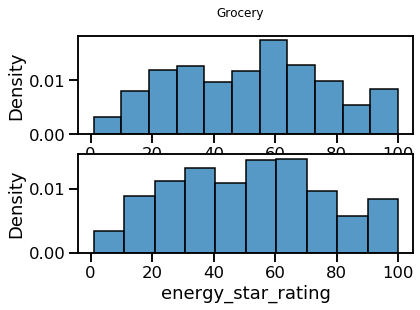

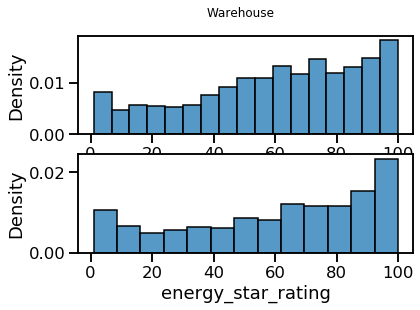

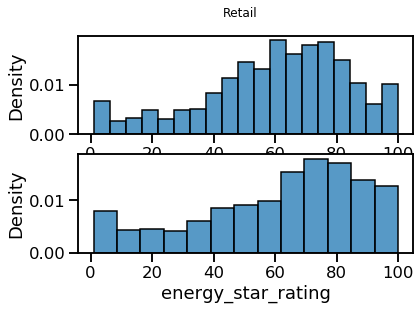

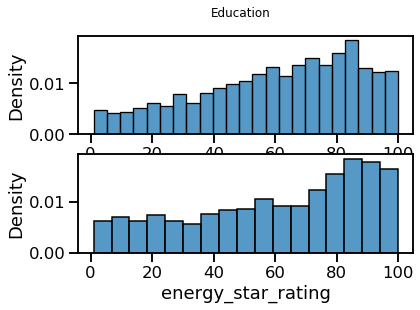

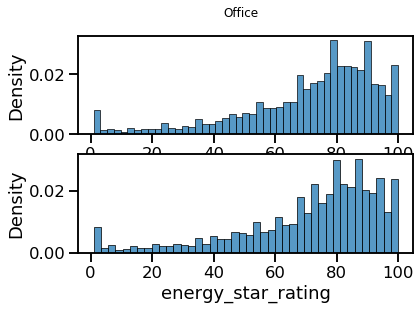

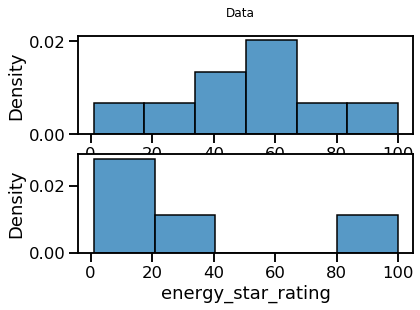

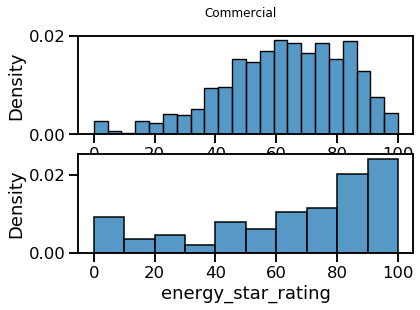

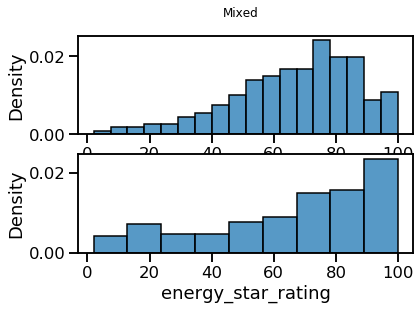

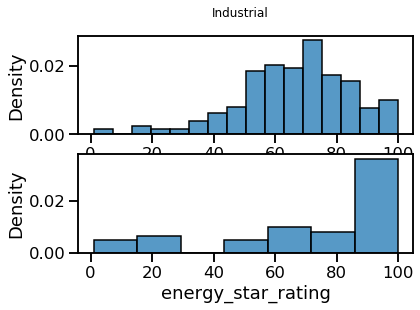

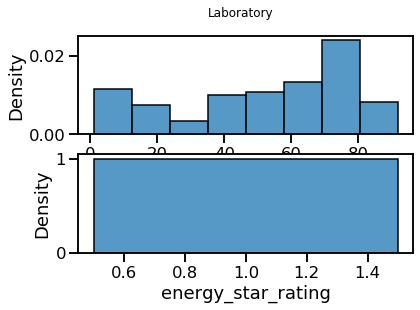

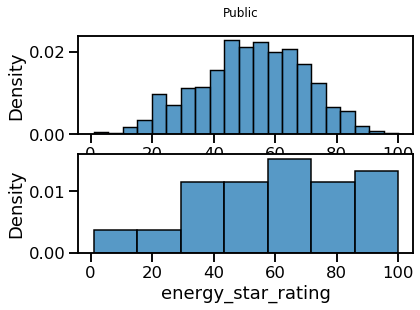

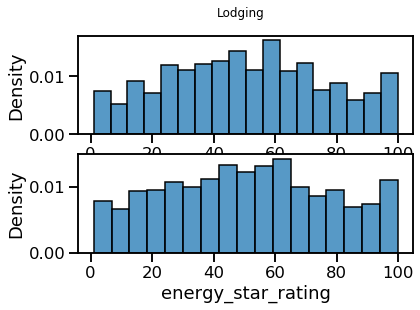

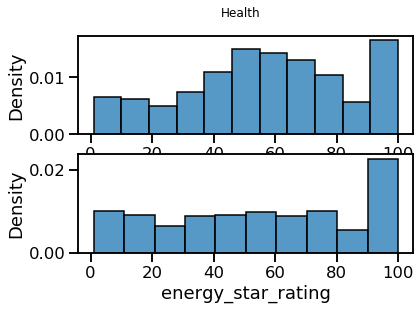

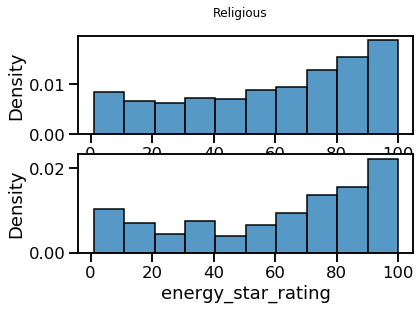

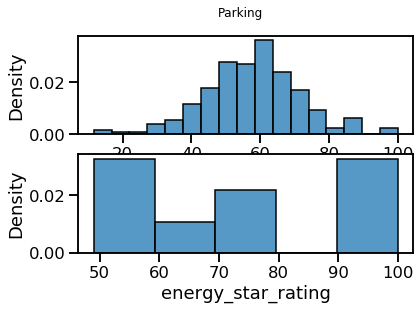

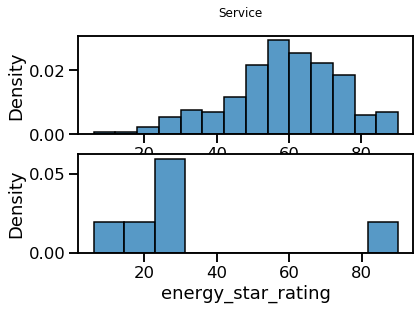

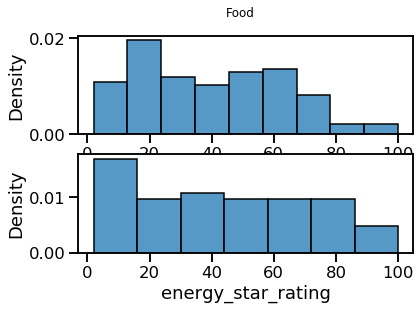

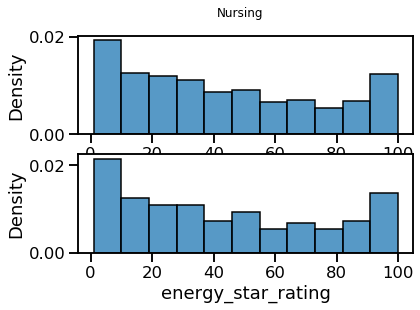

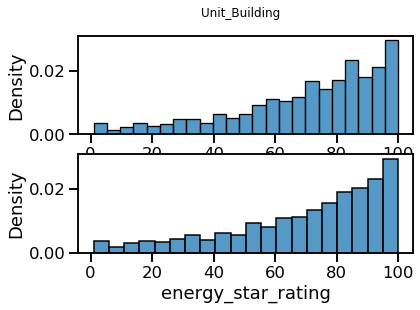

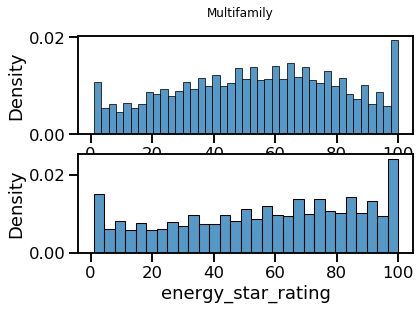

<IPython.core.display.Javascript object>

In [15]:
# Data, laboratory, industrial/commercial, parking
for ftp in imputed_train_x_df["facility_type_parsed"].unique():
    fig, axes = plt.subplots(nrows=2)
    sns.histplot(
        data=imputed_train_x_df.query(f"facility_type_parsed == @ftp"),
        x="energy_star_rating",
        stat="density",
        ax=axes[0],
    )
    sns.histplot(
        data=train_filter_x_df.query(f"facility_type_parsed == @ftp"),
        x="energy_star_rating",
        stat="density",
        ax=axes[1],
    )
    fig.suptitle(ftp)

# Older code

Fitting PCA with 11 components
log_all_env_pca_onehot_impute ['temp_pca4', 'temp_pca5', 'temp_pca1', 'temp_pca11', 'temp_pca6', 'state_factor', 'log10_elevation', 'temp_pca8', 'temp_pca9', 'building_class', 'facility_type_parsed', 'temp_pca3', 'year_built', 'temp_pca7', 'temp_pca2', 'temp_pca10', 'log10_floor_area', 'backfilled_energy_star_rating'] True
Running catboost
Modeling 1...
Modeling 2...
Modeling 3...
Modeling 4...
Modeling 5...
Modeling 6...
Average RMSE:
left_out_year     3.50000
train_rmse       26.64198
test_rmse        48.00580
dtype: float64
Whole data train RMSE: 26.89945359695467


,left_out_year,train_rmse,test_rmse,method
0,1.0,26.733287,53.970891,loyo
1,2.0,25.919471,41.478696,loyo
2,3.0,24.700964,46.597839,loyo
3,4.0,26.891658,42.270688,loyo
4,5.0,28.100443,55.244168,loyo
5,6.0,27.506058,48.472521,loyo
6,0.0,26.899454,NaN,whole train


/Users/diana/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fitting PCA with 9 components
log_temp_pca_onehot_impute ['temp_pca4', 'temp_pca5', 'temp_pca1', 'heating_degree_days', 'snowfall_inches', 'snowdepth_inches', 'temp_pca6', 'days_above_100f', 'state_factor', 'days_below_10f', 'log10_elevation', 'temp_pca9', 'temp_pca8', 'building_class', 'days_below_0f', 'days_above_90f', 'cooling_degree_days', 'days_below_20f', 'facility_type_parsed', 'temp_pca3', 'year_built', 'days_above_80f', 'precipitation_inches', 'temp_pca7', 'temp_pca2', 'days_below_30f', 'days_above_110f', 'log10_floor_area', 'backfilled_energy_star_rating'] True
Running catboost
Modeling 1...
Modeling 2...
Modeling 3...
Modeling 4...
Modeling 5...
Modeling 6...
Average RMSE:
left_out_year     3.500000
train_rmse       26.646369
test_rmse        44.670210
dtype: float64
Whole data train RMSE: 27.02124320708529


,left_out_year,train_rmse,test_rmse,method
0,1.0,26.623324,56.768286,loyo
1,2.0,25.918368,43.168738,loyo
2,3.0,24.778519,47.090468,loyo
3,4.0,26.799104,38.178778,loyo
4,5.0,28.138988,35.840377,loyo
5,6.0,27.619912,46.974611,loyo
6,0.0,27.021243,NaN,whole train


/Users/diana/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fitting PCA with 11 components
log_all_env_pca_onehot ['year_built', 'building_class', 'energy_star_rating', 'state_factor', 'temp_pca1', 'temp_pca2', 'temp_pca3', 'temp_pca4', 'temp_pca5', 'temp_pca6', 'temp_pca7', 'temp_pca8', 'temp_pca9', 'temp_pca10', 'temp_pca11', 'log10_floor_area', 'log10_elevation', 'facility_type_parsed'] True
Running catboost
Modeling 1...
Modeling 2...
Modeling 3...
Modeling 4...
Modeling 5...
Modeling 6...
Average RMSE:
left_out_year     3.500000
train_rmse       26.258129
test_rmse        44.883127
dtype: float64
Whole data train RMSE: 26.44535034203078


,left_out_year,train_rmse,test_rmse,method
0,1.0,26.320088,53.469788,loyo
1,2.0,25.512747,41.267575,loyo
2,3.0,24.391970,46.048604,loyo
3,4.0,26.254292,39.041293,loyo
4,5.0,27.626643,41.427096,loyo
5,6.0,27.443036,48.044409,loyo
6,0.0,26.445350,NaN,whole train


/Users/diana/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fitting PCA with 9 components
log_temp_pca_onehot ['heating_degree_days', 'year_built', 'snowfall_inches', 'snowdepth_inches', 'days_above_100f', 'state_factor', 'days_below_10f', 'days_above_80f', 'precipitation_inches', 'days_above_110f', 'building_class', 'days_below_20f', 'days_below_0f', 'days_below_30f', 'days_above_90f', 'cooling_degree_days', 'energy_star_rating', 'temp_pca1', 'temp_pca2', 'temp_pca3', 'temp_pca4', 'temp_pca5', 'temp_pca6', 'temp_pca7', 'temp_pca8', 'temp_pca9', 'log10_floor_area', 'log10_elevation', 'facility_type_parsed'] True
Running catboost
Modeling 1...
Modeling 2...
Modeling 3...
Modeling 4...
Modeling 5...
Modeling 6...
Average RMSE:
left_out_year     3.500000
train_rmse       26.432812
test_rmse        44.269688
dtype: float64
Whole data train RMSE: 26.674438413110973


,left_out_year,train_rmse,test_rmse,method
0,1.0,26.482323,55.498124,loyo
1,2.0,25.597441,42.345589,loyo
2,3.0,24.757740,46.994775,loyo
3,4.0,26.474521,38.202378,loyo
4,5.0,27.849465,35.565077,loyo
5,6.0,27.435384,47.012189,loyo
6,0.0,26.674438,NaN,whole train


/Users/diana/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


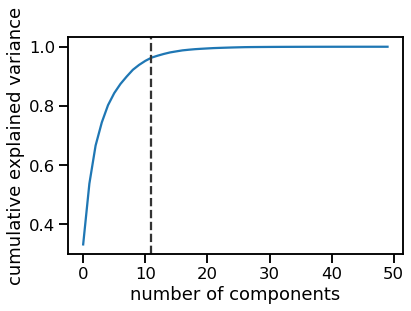

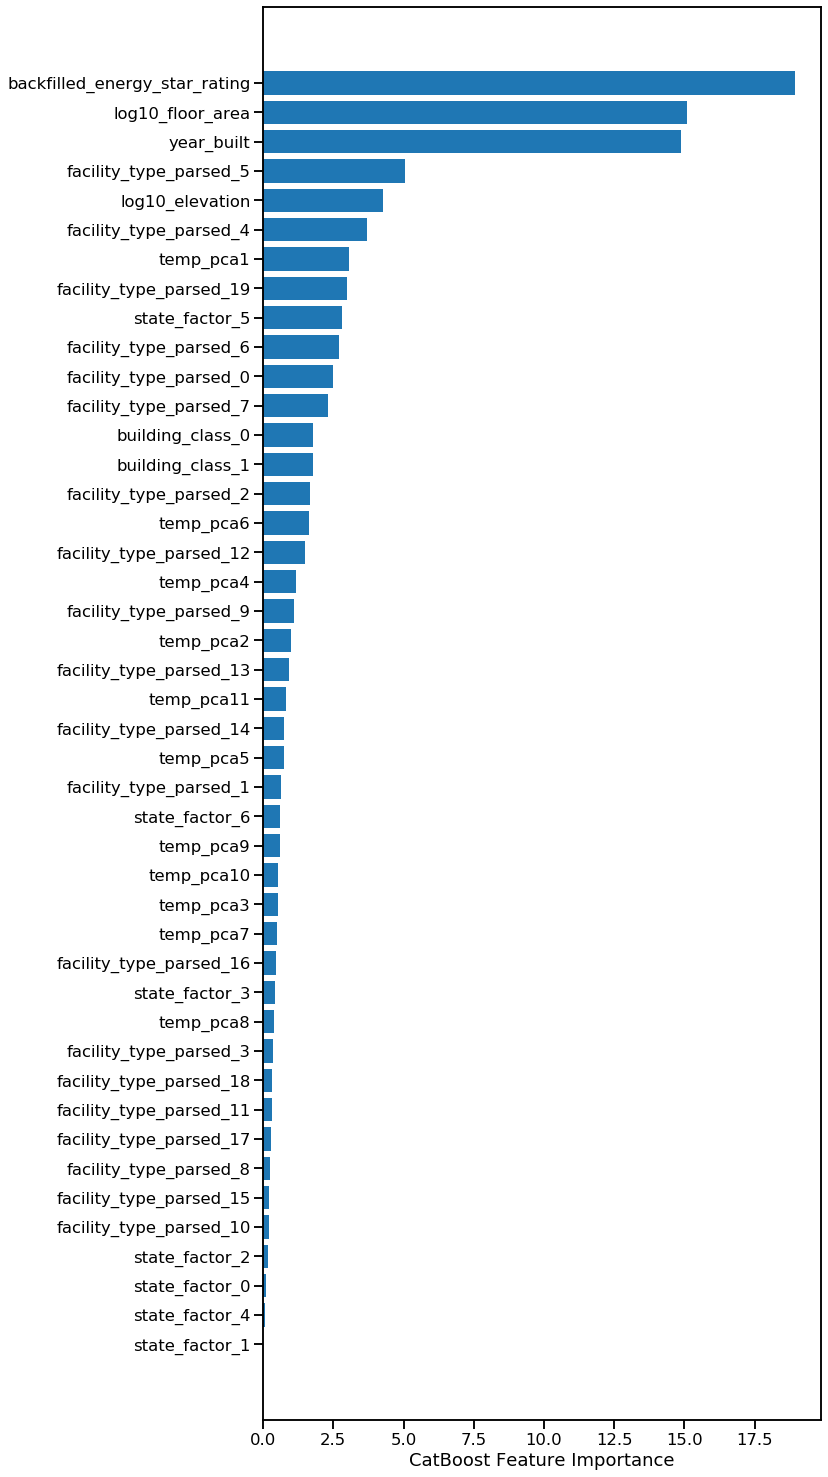

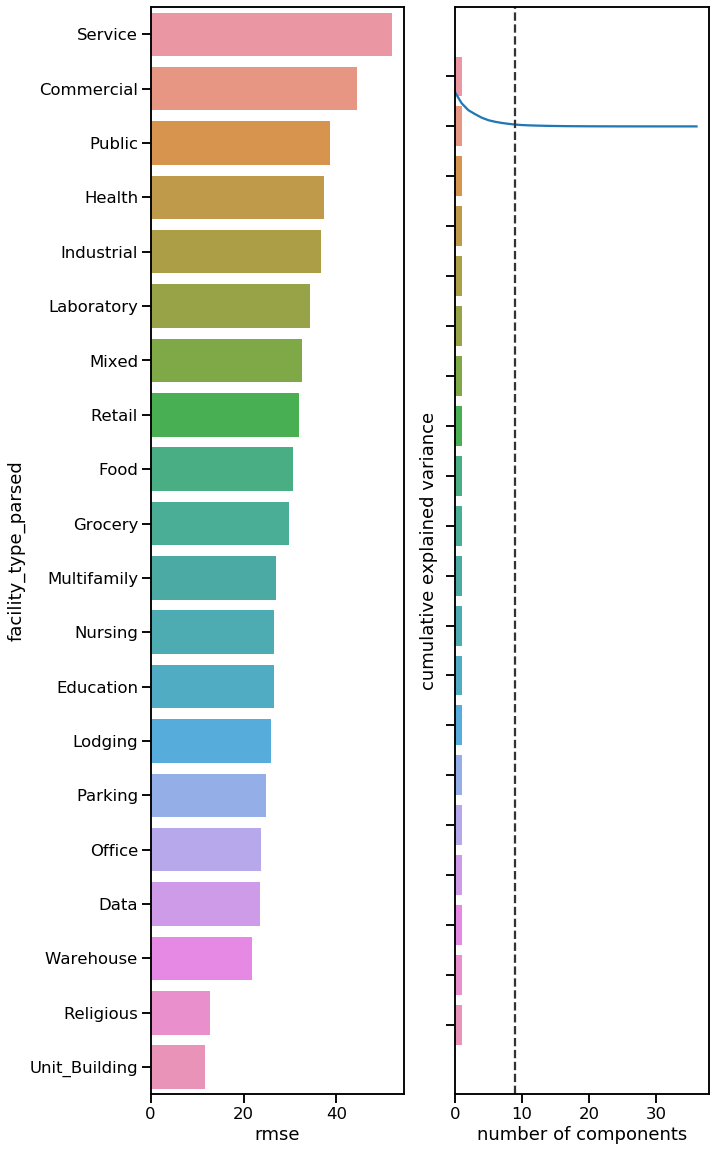

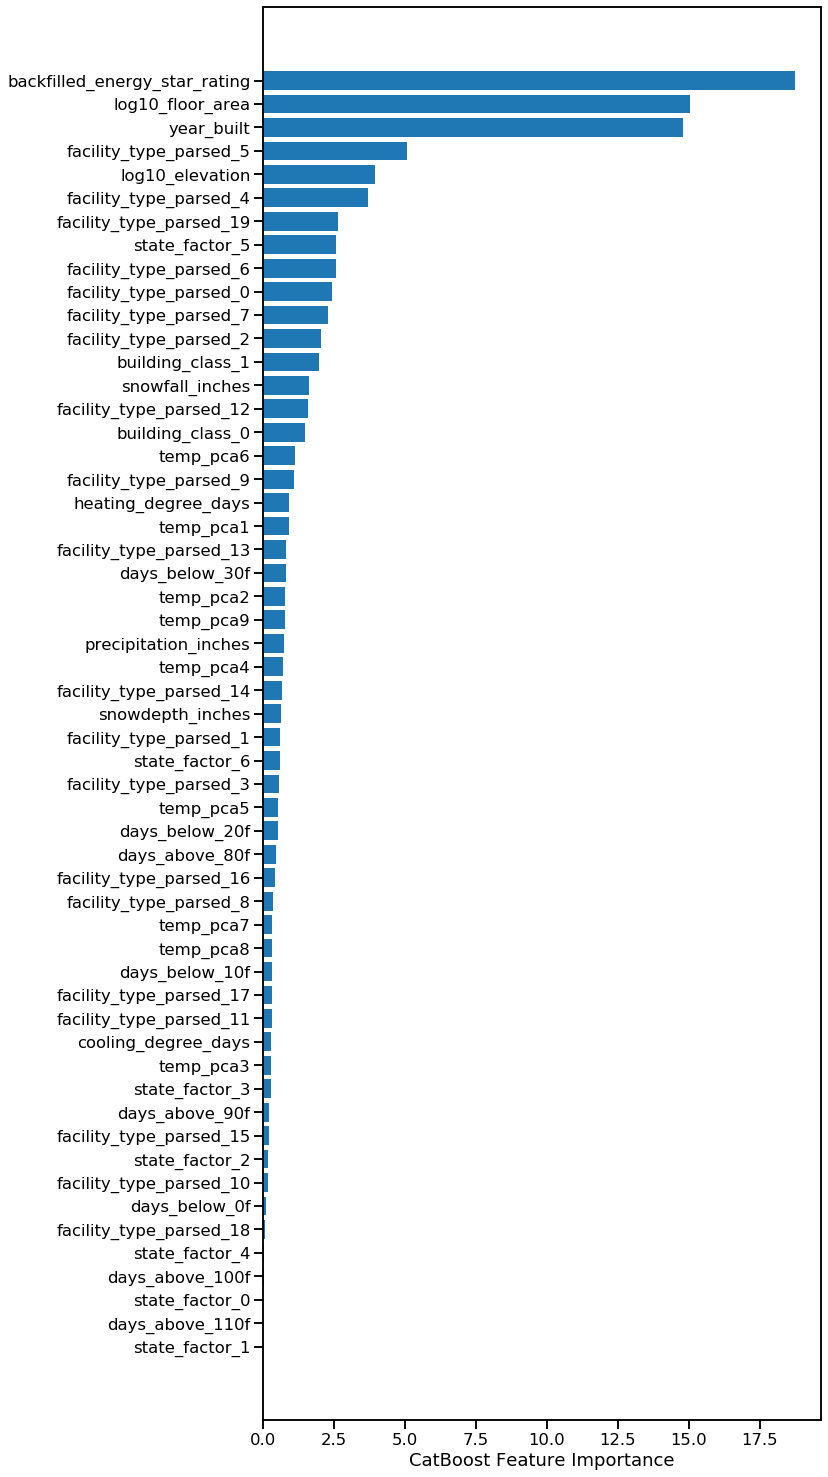

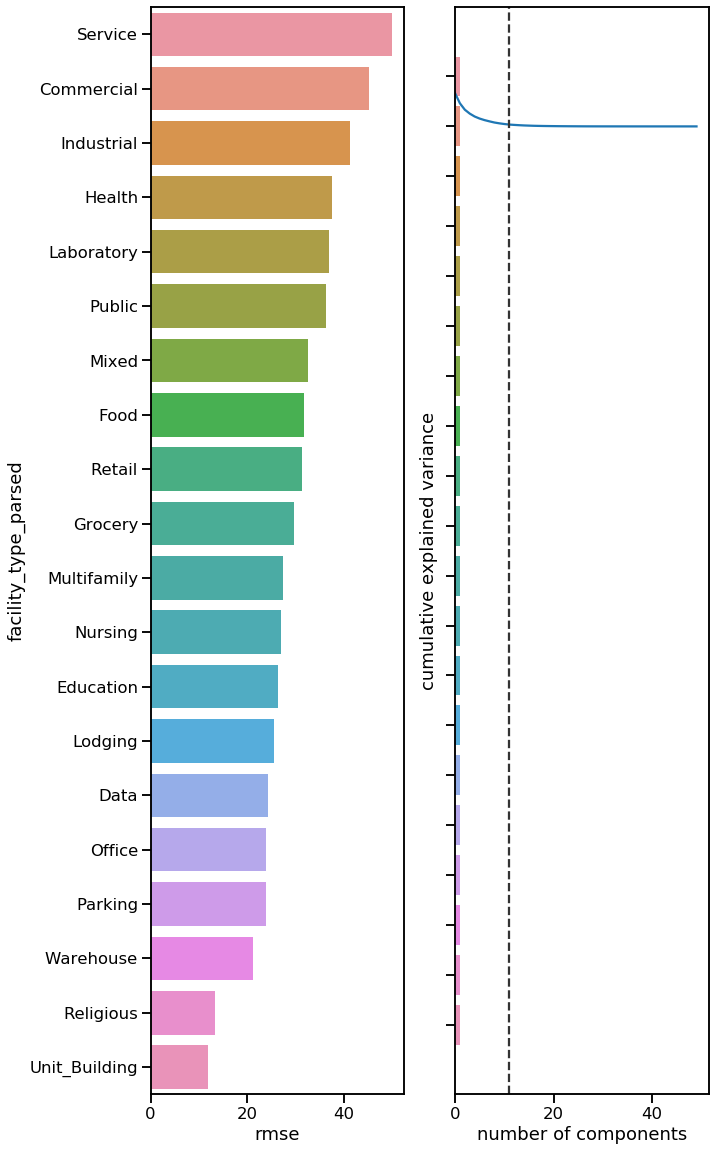

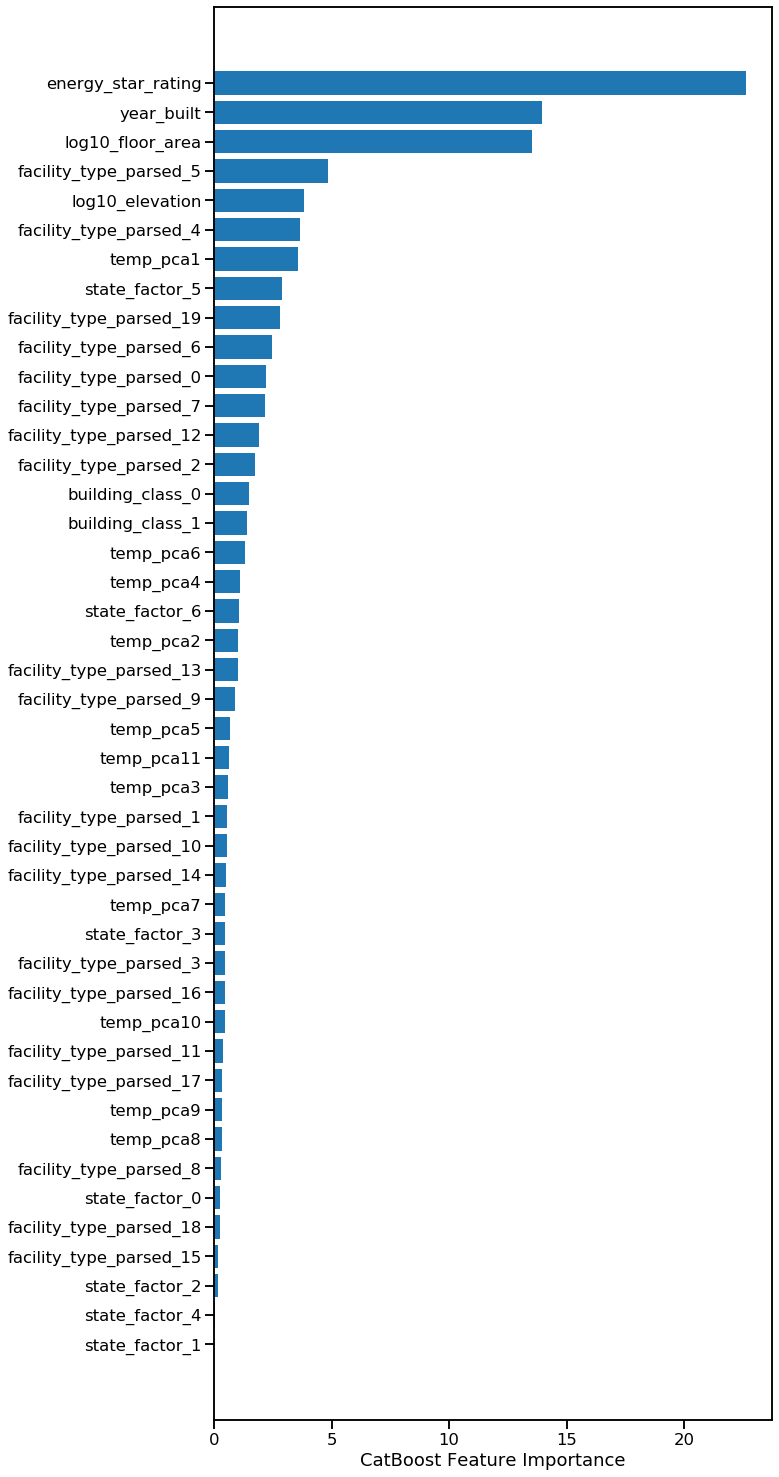

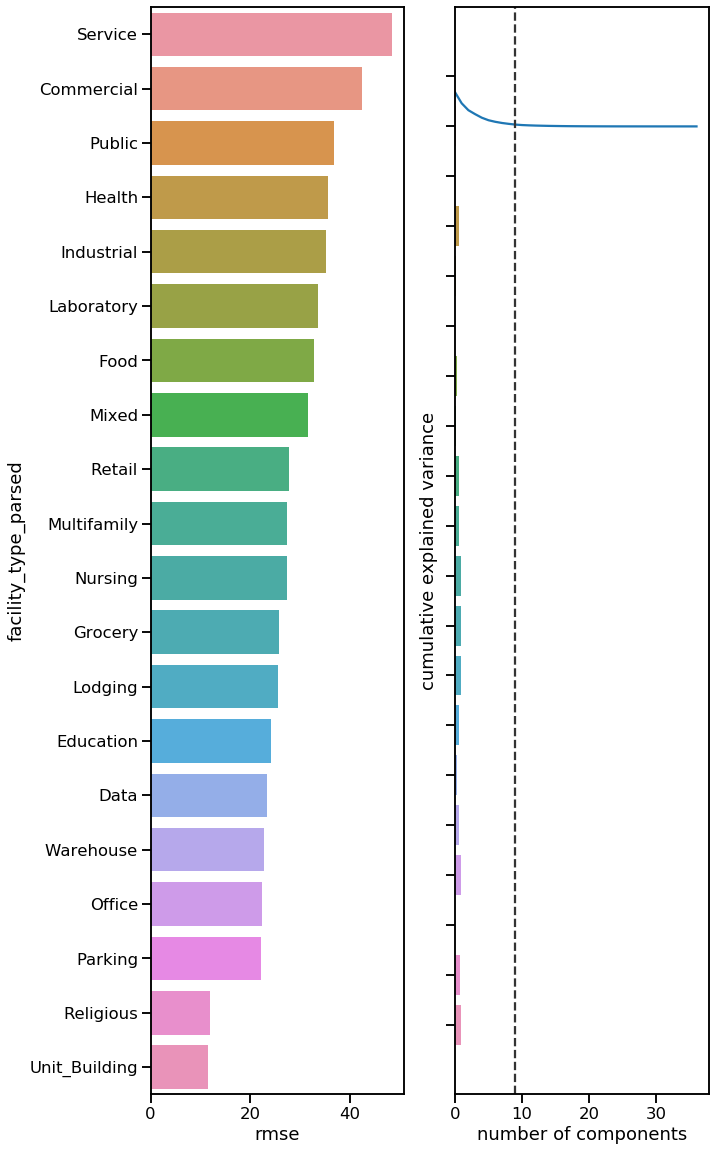

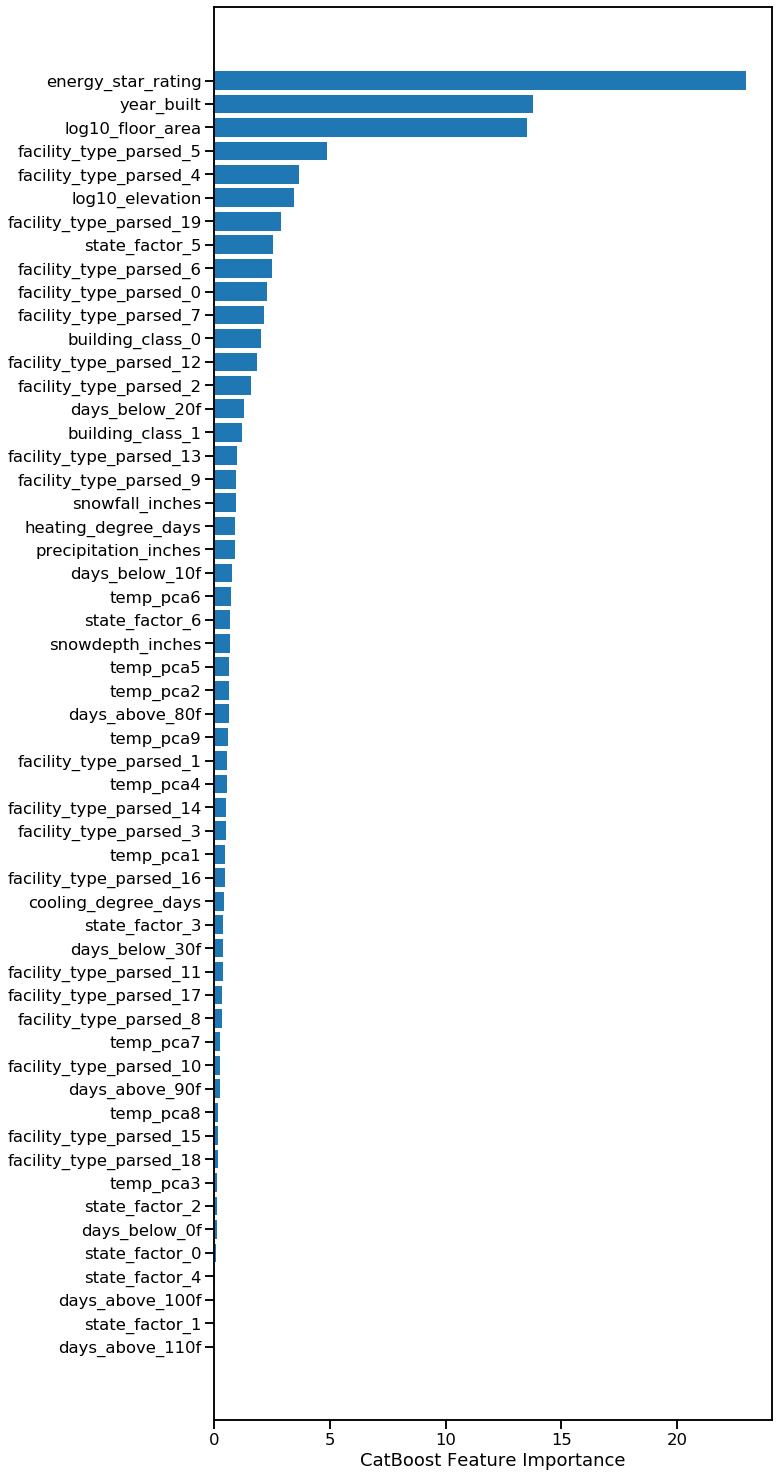

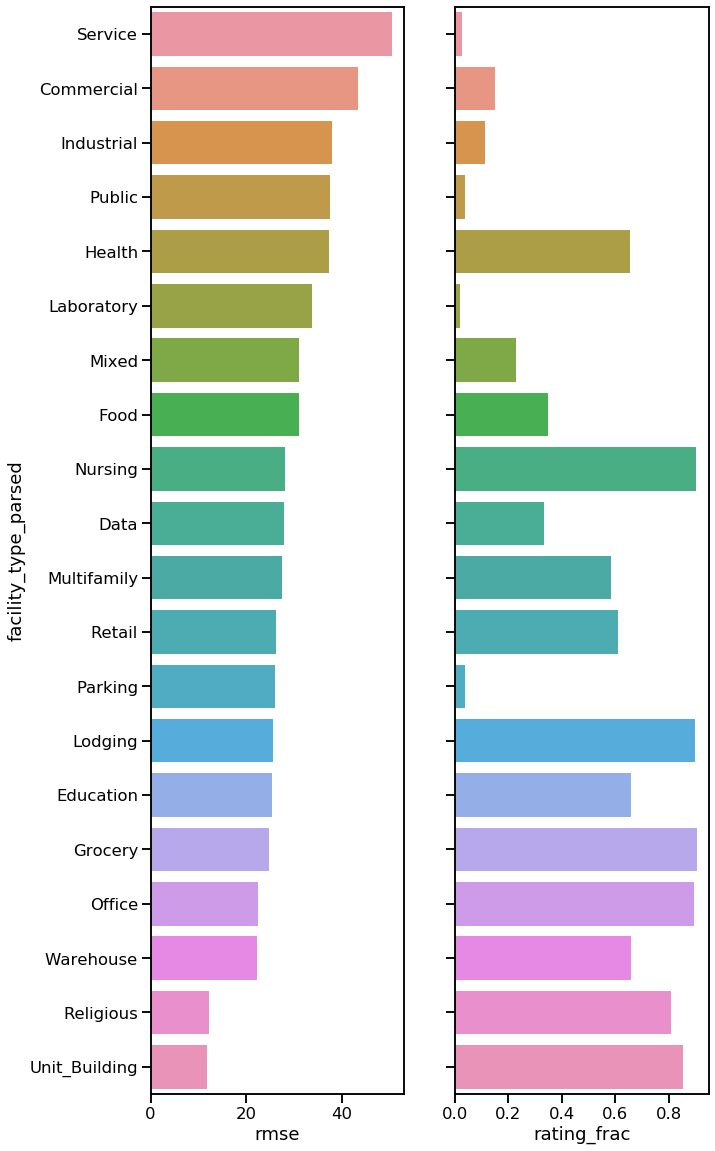

<IPython.core.display.Javascript object>

In [9]:
# Loop for different input configs, hyper parameter values
seed = 0
config_test_list = [
    "log_all_env_pca_onehot_impute",
    "log_temp_pca_onehot_impute",
    "log_all_env_pca_onehot",
    "log_temp_pca_onehot",
]
model_type = "catboost"
for config_name in config_test_list:  # feature_dict.keys():
    cols_to_reduce = feature_dict[config_name]["cols_to_reduce"]
    log10_transform_cols = feature_dict[config_name]["log10_transform_cols"]
    backfill_dict = feature_dict[config_name]["backfill_dict"]
    if_scale = False
    if_one_hot = feature_dict[config_name]["if_one_hot"]
    seed = 0

    train_filter_df, test_filter_df, pca_cols = process_data(
        train_df.drop_duplicates().copy(),
        test_df.drop_duplicates().copy(),
        cols_to_reduce,
        log10_transform_cols,
        0,
        backfill_dict,
    )
    if backfill_dict:
        # Backfill energy star rating again with coarser groupby
        train_filter_df = backfill_energy_star_rating(
            input_df=train_filter_df,
            mapping_df=train_filter_df,
            groupby_list=["state_factor", "building_class"],
            energy_star_rating_colname="backfilled_energy_star_rating",
            agg_approach_func=np.nanmedian,
        )
        test_filter_df = backfill_energy_star_rating(
            input_df=test_filter_df,
            mapping_df=train_filter_df,
            groupby_list=["state_factor", "building_class"],
            energy_star_rating_colname="backfilled_energy_star_rating",
            agg_approach_func=np.nanmedian,
        )

        train_filter_df, test_filter_df = clean_impute_data(
            train_filter_df,
            test_filter_df,
            impute_col="year_built",
            impute_thresh=1800,
            factors_cols=["building_class", "state_factor"],
        )

    # Set feature columns after data transformations
    features_columns = (
        list(
            set(all_feature_columns)
            - set(cols_to_reduce)
            - set(log10_transform_cols)
            - set(cols_to_drop)
        )
        + pca_cols
        + [f"log10_{col}" for col in log10_transform_cols]
        + ["facility_type_parsed"]
    )
    if backfill_dict:
        backfill_cols = list(backfill_dict.keys())
        features_columns = list(set(features_columns) - set(backfill_cols)) + [
            f"backfilled_{col}" for col in backfill_cols
        ]
    print(config_name, features_columns, if_one_hot)

    # From previous runs, depth=12 yielded best performance.
    for depth in [12]:  # [6, 8, 10, 12]:
        model = cb.CatBoostRegressor(
            loss_function="RMSE",
            depth=depth,
            random_seed=seed,
            verbose=False,
            nan_mode="Min",
        )

        ## Run LOY model
        catboost_rmse = mu.run_leave_year_out(
            model_df=train_filter_df,
            ml_model=model,
            features_columns=features_columns,
            if_scale_data=if_scale,
            if_one_hot=if_one_hot,
            model_type=model_type,
        )
        print(f"Average RMSE:\n{catboost_rmse.mean()}")

        ## predict on test data
        train_filter_x_df, train_filter_y_df = mu.split_model_feature_response(
            train_filter_df, features_columns
        )
        test_filter_x_df = mu.split_model_feature_response(
            test_filter_df, features_columns, if_with_response=False
        )
        processed_train_x_df, processed_test_x_df = mu.process_train_test_data(
            train_filter_x_df, test_filter_x_df, if_scale, if_one_hot, train_filter_df,
        )

        train_predict, test_predict, fitted_model = run_model_dict[model_type](
            model, processed_train_x_df, train_filter_y_df, processed_test_x_df
        )
        training_rmse = mu.calculate_rmse(train_filter_y_df, train_predict)
        print(f"Whole data train RMSE: {training_rmse}")

        ## output save result
        catboost_rmse.loc[catboost_rmse.shape[0], :] = [0, training_rmse, np.nan]
        catboost_rmse["method"] = catboost_rmse["left_out_year"].apply(
            lambda x: "loyo" if x > 0 else "whole train"
        )
        display(catboost_rmse)
        catboost_rmse.to_csv(
            f"{wids_path}/validation_result/diana/{model_type}_{config_name}_depth{depth}_seed{seed}.csv",
            index=False,
        )

        test_prediction_result = test_df[["id"]]
        test_prediction_result["site_eui"] = test_predict
        test_prediction_result.to_csv(
            f"{wids_path}/prediction_result/diana/{model_type}_{config_name}_depth{depth}_seed{seed}.csv",
            index=False,
        )

        plot_catboost_feature_importance(model)
        plt.savefig(
            f"{wids_path}/validation_result/diana/{model_type}_{config_name}_feature_importance_depth{depth}_seed{seed}.png"
        )

        rmse_df = get_rmse_by_group(
            train_filter_x_df.rename(
                columns={"backfilled_energy_star_rating": "energy_star_rating"}
            ),
            train_filter_y_df,
            train_predict,
            group_cols=["facility_type_parsed"],
        )
        plot_rmse_by_group(rmse_df, group_col="facility_type_parsed")
        plt.savefig(
            f"{wids_path}/validation_result/diana/{model_type}_{config_name}_rmse_by_group_depth{depth}_seed{seed}.png"
        )

Fitting PCA with 11 components
log_all_env_pca_onehot_impute ['temp_pca4', 'temp_pca5', 'temp_pca1', 'temp_pca11', 'temp_pca6', 'state_factor', 'log10_elevation', 'temp_pca8', 'temp_pca9', 'building_class', 'facility_type_parsed', 'temp_pca3', 'year_built', 'temp_pca7', 'temp_pca2', 'temp_pca10', 'log10_floor_area', 'backfilled_energy_star_rating'] True
Running dnn
Modeling 1...
Modeling 2...
Modeling 3...
Modeling 4...
Modeling 5...
Modeling 6...
Average RMSE:
left_out_year     3.500000
train_rmse       45.491421
test_rmse        49.880752
dtype: float64
Whole data train RMSE: 53.631395440418146


,left_out_year,train_rmse,test_rmse,method
0,1.0,42.921135,63.258622,loyo
1,2.0,44.765666,47.272807,loyo
2,3.0,45.707511,55.641333,loyo
3,4.0,44.041338,44.161477,loyo
4,5.0,48.169154,43.569411,loyo
5,6.0,47.343721,45.380862,loyo
6,0.0,53.631395,NaN,whole train


/Users/diana/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


KeyError: 'facility_type'

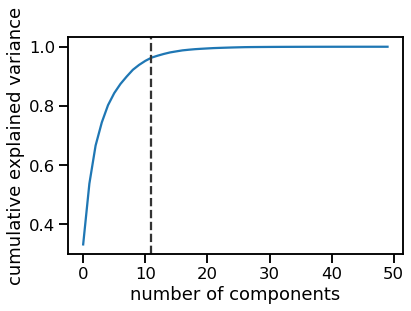

<IPython.core.display.Javascript object>

In [4]:
# Test dnn performance
seed = 0
config_test_list = ["log_all_env_pca_onehot_impute", "log_temp_pca_onehot_impute"]
model_type = "dnn"
depth = 0
for config_name in config_test_list:  # feature_dict.keys():
    cols_to_reduce = feature_dict[config_name]["cols_to_reduce"]
    log10_transform_cols = feature_dict[config_name]["log10_transform_cols"]
    backfill_dict = feature_dict[config_name]["backfill_dict"]
    if_scale = False
    if_one_hot = feature_dict[config_name]["if_one_hot"]
    seed = 0

    train_filter_df, test_filter_df, pca_cols = process_data(
        train_df.drop_duplicates().copy(),
        test_df.drop_duplicates().copy(),
        cols_to_reduce,
        log10_transform_cols,
        0,
        backfill_dict,
    )
    if backfill_dict:
        # Backfill energy star rating again with coarser groupby
        train_filter_df = backfill_energy_star_rating(
            input_df=train_filter_df,
            mapping_df=train_filter_df,
            groupby_list=["state_factor", "building_class"],
            energy_star_rating_colname="backfilled_energy_star_rating",
            agg_approach_func=np.nanmedian,
        )
        test_filter_df = backfill_energy_star_rating(
            input_df=test_filter_df,
            mapping_df=train_filter_df,
            groupby_list=["state_factor", "building_class"],
            energy_star_rating_colname="backfilled_energy_star_rating",
            agg_approach_func=np.nanmedian,
        )

        train_filter_df, test_filter_df = clean_impute_data(
            train_filter_df,
            test_filter_df,
            impute_col="year_built",
            impute_thresh=1800,
            factors_cols=["building_class", "state_factor"],
        )

    # Set feature columns after data transformations
    features_columns = (
        list(
            set(all_feature_columns)
            - set(cols_to_reduce)
            - set(log10_transform_cols)
            - set(cols_to_drop)
        )
        + pca_cols
        + [f"log10_{col}" for col in log10_transform_cols]
        + ["facility_type_parsed"]
    )
    if backfill_dict:
        backfill_cols = list(backfill_dict.keys())
        features_columns = list(set(features_columns) - set(backfill_cols)) + [
            f"backfilled_{col}" for col in backfill_cols
        ]
    print(config_name, features_columns, if_one_hot)

    model = None

    ## Run LOY model
    catboost_rmse = mu.run_leave_year_out(
        model_df=train_filter_df,
        ml_model=model,
        features_columns=features_columns,
        if_scale_data=if_scale,
        if_one_hot=if_one_hot,
        model_type=model_type,
    )
    print(f"Average RMSE:\n{catboost_rmse.mean()}")

    ## predict on test data
    train_filter_x_df, train_filter_y_df = mu.split_model_feature_response(
        train_filter_df, features_columns
    )
    test_filter_x_df = mu.split_model_feature_response(
        test_filter_df, features_columns, if_with_response=False
    )
    processed_train_x_df, processed_test_x_df = mu.process_train_test_data(
        train_filter_x_df, test_filter_x_df, if_scale, if_one_hot, train_filter_df,
    )

    train_predict, test_predict, fitted_model = run_model_dict[model_type](
        model, processed_train_x_df, train_filter_y_df, processed_test_x_df, 
    )
    training_rmse = mu.calculate_rmse(train_filter_y_df, train_predict)
    print(f"Whole data train RMSE: {training_rmse}")

    ## output save result
    catboost_rmse.loc[catboost_rmse.shape[0], :] = [0, training_rmse, np.nan]
    catboost_rmse["method"] = catboost_rmse["left_out_year"].apply(
        lambda x: "loyo" if x > 0 else "whole train"
    )
    display(catboost_rmse)
    catboost_rmse.to_csv(
        f"{wids_path}/validation_result/diana/{model_type}_{config_name}_depth{depth}_seed{seed}.csv",
        index=False,
    )

    test_prediction_result = test_df[["id"]]
    test_prediction_result["site_eui"] = test_predict
    test_prediction_result.to_csv(
        f"{wids_path}/prediction_result/diana/{model_type}_{config_name}_depth{depth}_seed{seed}.csv",
        index=False,
    )

    rmse_df = get_rmse_by_group(
        train_filter_x_df.rename(
            columns={"backfilled_energy_star_rating": "energy_star_rating"}
        ),
        train_filter_y_df,
        train_predict,
        group_cols=["facility_type_parsed"],
    )
    plot_rmse_by_group(rmse_df, group_col="facility_type_parsed")
    plt.savefig(
        f"{wids_path}/validation_result/diana/{model_type}_{config_name}_rmse_by_group_depth{depth}_seed{seed}.png"
    )

In [7]:
plot_rmse_by_group?

<IPython.core.display.Javascript object>

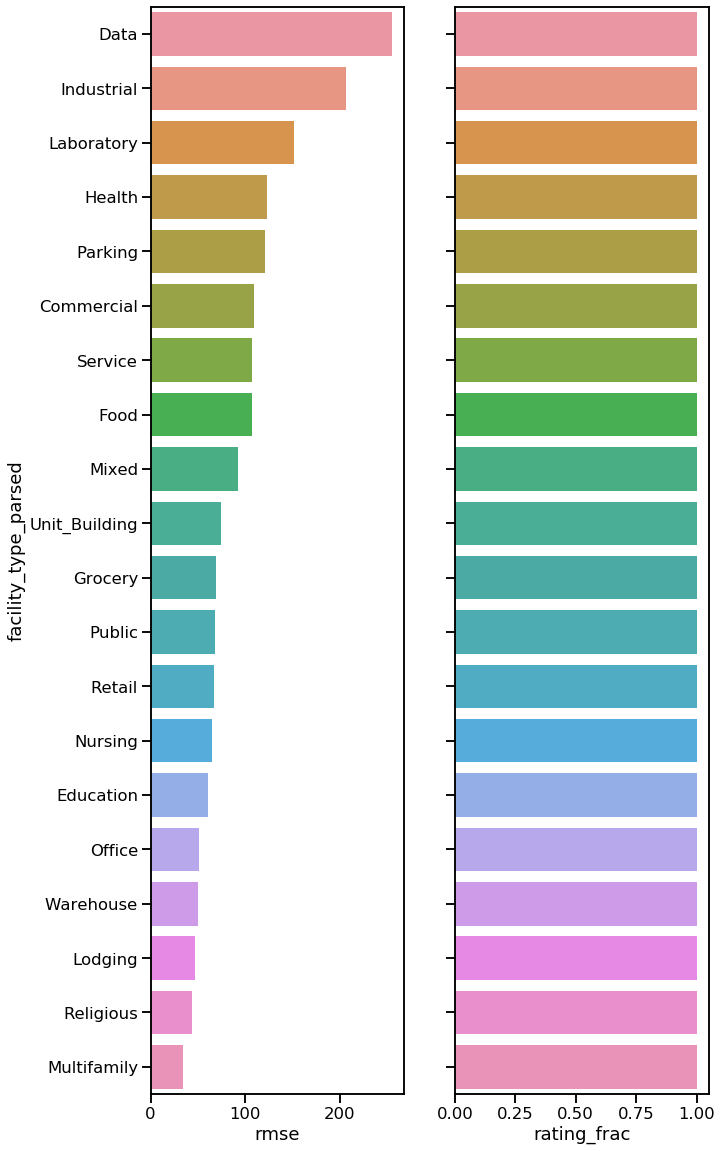

<IPython.core.display.Javascript object>

In [10]:
model.get_all_params()

{'nan_mode': 'Max',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 0,
 'depth': 12,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.08111999928951263,
 'score_function': 'Cosine',
 'task_type

<IPython.core.display.Javascript object>

In [10]:
# fig, axes = plt.subplots(ncols=2, figsize=(11, 5))
# sns.barplot(data=pd.melt(catboost_rmse, id_vars=['left_out_year', 'method']),
#                  x='left_out_year', y='value', hue='variable', ax = axes[0])
# axes[0].legend([])
# sns.barplot(data=pd.melt(catboost_rmse, id_vars=['left_out_year', 'method']),
#             x='method', y='value', hue='variable', ax=axes[1])
# axes[1].legend(bbox_to_anchor=(1,1))
# plt.savefig(f"{wids_path}/validation_result/{config_name}_rmse_summary.png")

<IPython.core.display.Javascript object>

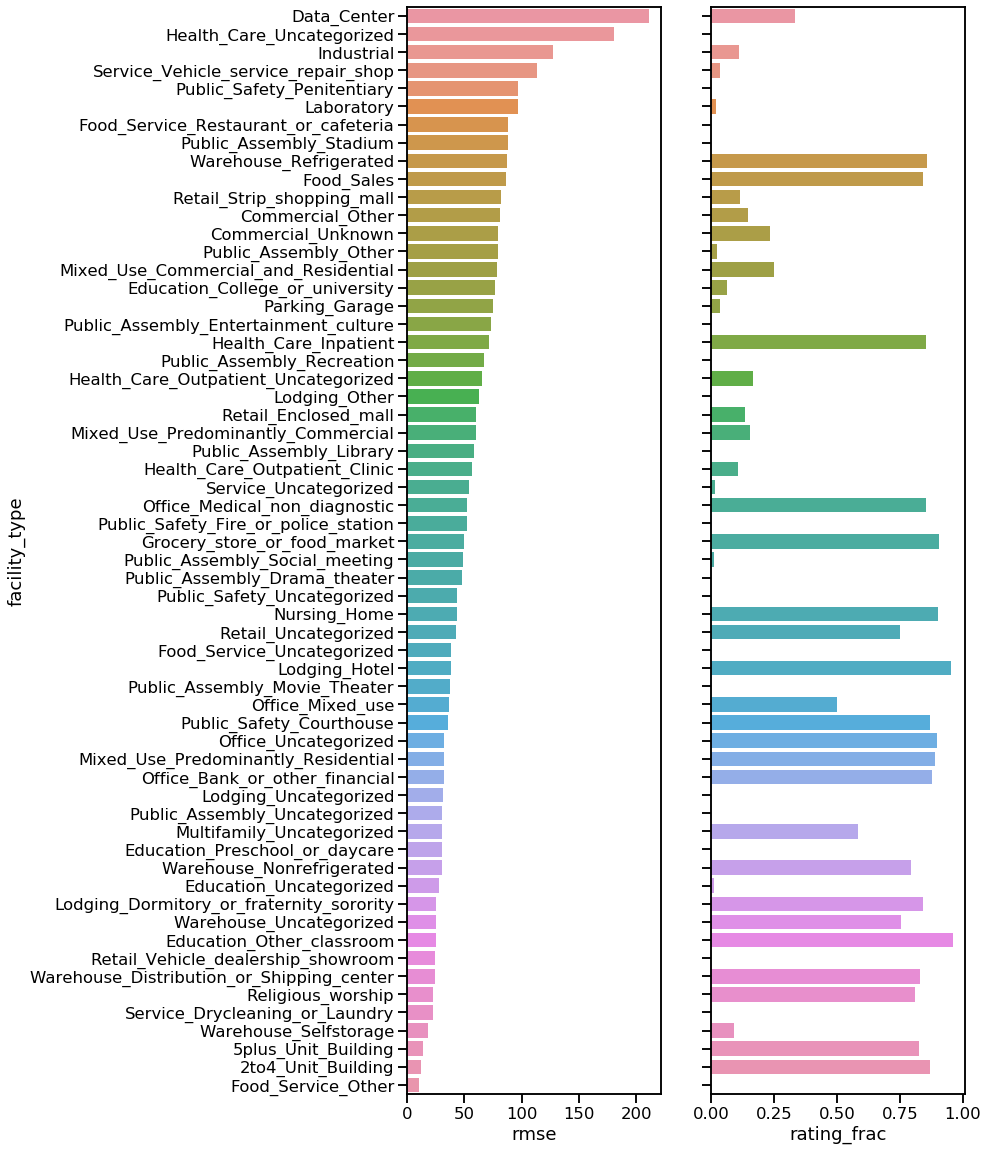

<IPython.core.display.Javascript object>

# Dev cells below this point

In [13]:
model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0

<IPython.core.display.Javascript object>

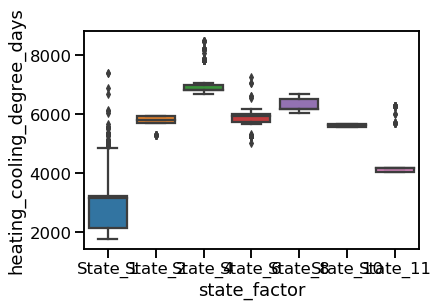

In [14]:
train_filter_df['heating_cooling_degree_days'] = train_filter_df['heating_degree_days'] + train_filter_df['cooling_degree_days']
sns.boxplot(data=train_filter_df, x='state_factor', y='heating_cooling_degree_days')

/Users/diana/anaconda/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:1213: UserWarning: No contour levels were found within the data range.
  **contour_kws,


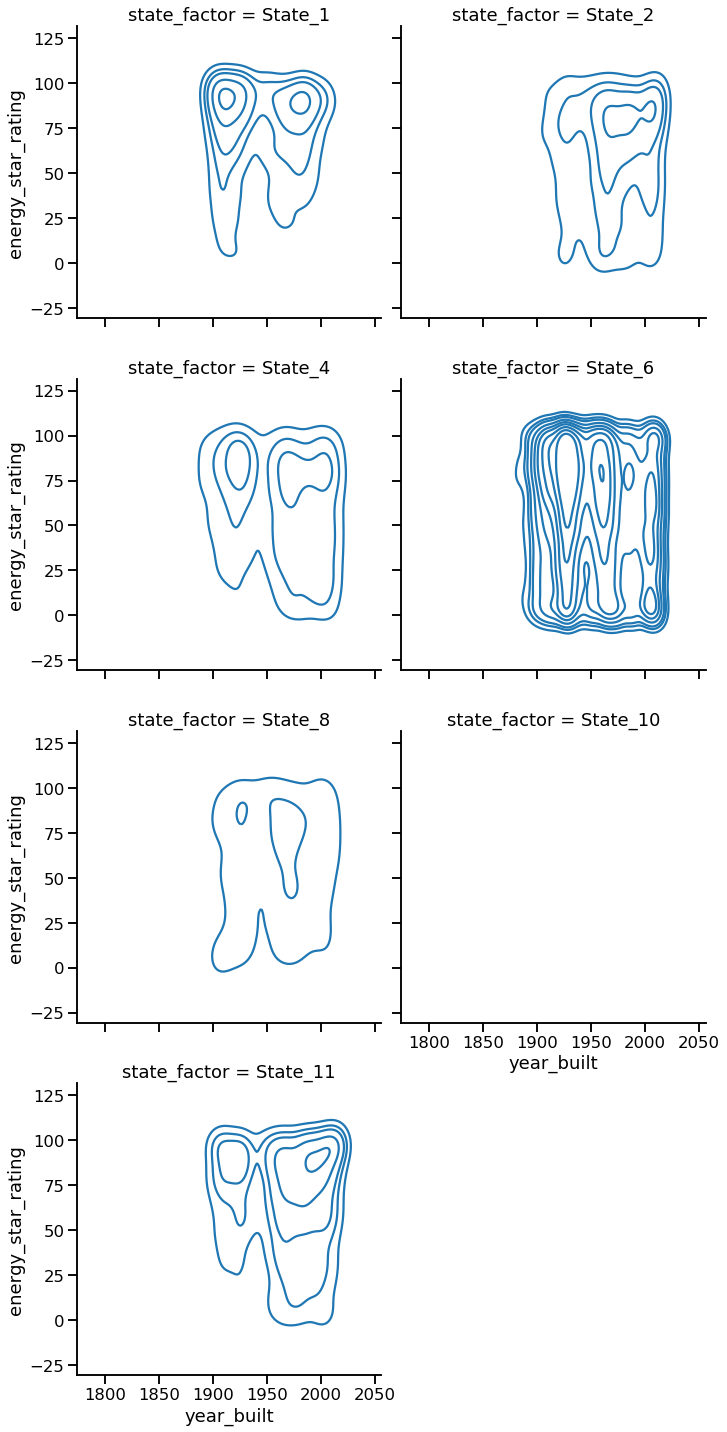

In [40]:
sns.displot(data=train_df.query("year_built>1800"), x='year_built', y='energy_star_rating', col='state_factor',
            col_wrap=2, kind='kde')

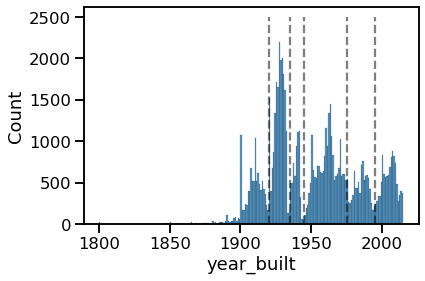

In [31]:
ax = sns.histplot(train_filter_df['year_built'], binwidth=1)
year_built_bins = [1800, 1920, 1935, 1945, 1975, 1995, 2022]
ax.vlines(year_built_bins, ymin=0, ymax=2500, linestyles='--', alpha=0.5)

# norm = plt.Normalize(train_filter_df['site_eui'].min(), train_filter_df['site_eui'].max())
# sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
# sm.set_array([])

# # Remove the legend and add a colorbar
# ax.get_legend().remove()
# ax.figure.colorbar(sm)

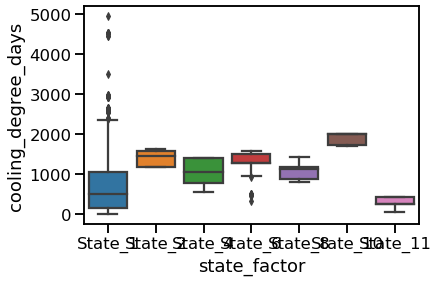

In [12]:
sns.boxplot(data=train_filter_df, x='state_factor', y='cooling_degree_days')

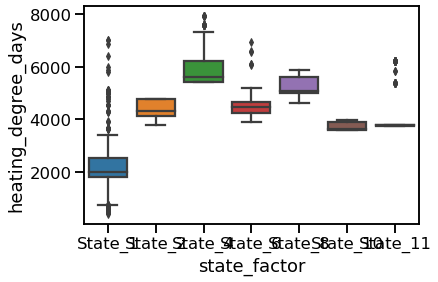

In [13]:
sns.boxplot(data=train_filter_df, x='state_factor', y='heating_degree_days')

In [7]:
merged_train_df = combine_features_and_prediction(train_filter_x_df, train_filter_y_df, train_predict)

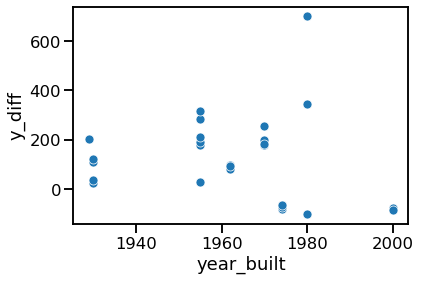

In [16]:
sns.scatterplot(data=merged_train_df.query("facility_type == 'Data_Center'"), x='year_built', y='y_diff')

In [20]:
merged_train_df.query("facility_type == 'Data_Center'")

,days_with_fog,max_wind_speed,year_built,energy_star_rating,direction_max_wind_speed,facility_type,direction_peak_wind_speed,state_factor,elevation,building_class,temp_pca1,temp_pca2,temp_pca3,temp_pca4,temp_pca5,temp_pca6,temp_pca7,temp_pca8,temp_pca9,temp_pca10,temp_pca11,log10_floor_area,y_true,y_pred,y_diff
13,NaN,1.0,1955.0,13.0,1.0,Data_Center,1.0,State_1,2.4,Commercial,9.899709,-3.664954,-2.872117,3.225393,-0.140553,-3.029312,0.462378,0.819529,-1.101217,-0.359836,0.923391,5.790140,608.839519,431.258818,177.580701
930,88.0,1.0,1955.0,14.0,1.0,Data_Center,1.0,State_1,2.4,Commercial,7.518657,3.457206,3.574886,3.848093,1.827769,-0.530686,-0.918268,-0.422340,-0.550403,-1.628838,-0.638583,5.790140,616.121303,425.027204,191.094098
1291,NaN,NaN,1955.0,19.0,NaN,Data_Center,NaN,State_1,2.4,Commercial,7.106097,3.361153,3.129690,3.997770,2.140610,1.388952,-0.196029,-0.454147,-0.178477,-1.323137,-0.558002,5.790140,656.063562,445.931537,210.132024
2505,NaN,NaN,1955.0,24.0,NaN,Data_Center,NaN,State_1,2.4,Commercial,10.970392,3.047361,-1.925137,3.131750,-0.112876,-2.462378,-0.800062,-1.030637,-0.534855,1.775066,1.415461,5.790140,752.066575,468.463168,283.603407
3599,NaN,NaN,1955.0,20.0,NaN,Data_Center,NaN,State_1,2.4,Commercial,8.413486,8.410656,4.567929,2.726743,3.824258,0.029617,2.210053,0.568842,-2.781827,-2.069750,-1.260825,5.790140,775.608943,459.798062,315.810881
4195,NaN,NaN,2000.0,NaN,NaN,Data_Center,NaN,State_1,9.1,Commercial,8.413486,8.410656,4.567929,2.726743,3.824258,0.029617,2.210053,0.568842,-2.781827,-2.069750,-1.260825,5.279190,40.395053,114.603068,-74.208015
4640,NaN,NaN,1955.0,1.0,NaN,Data_Center,NaN,State_1,2.4,Commercial,11.556235,-1.967200,-3.681439,3.868389,-0.633642,-3.298225,0.471599,-1.728747,0.185836,1.482774,0.220019,5.790140,524.064208,496.449437,27.614771
5239,NaN,NaN,2000.0,NaN,NaN,Data_Center,NaN,State_1,45.7,Commercial,11.556235,-1.967200,-3.681439,3.868389,-0.633642,-3.298225,0.471599,-1.728747,0.185836,1.482774,0.220019,5.279190,38.594262,121.418366,-82.824104
14842,12.0,1.0,1980.0,99.0,1.0,Data_Center,1.0,State_6,3.4,Commercial,-0.906130,1.185162,-0.191659,-1.535895,-0.678208,1.663895,0.557920,-1.453838,1.681902,-2.113088,0.466441,4.820077,502.542373,157.706680,344.835693
26916,93.0,1.0,1974.0,39.0,1.0,Data_Center,1.0,State_6,25.6,Commercial,-0.353112,0.033485,0.063749,-1.833425,2.561516,-1.113903,-1.056279,0.582233,0.647049,0.624359,-0.541793,6.040877,54.182890,118.480214,-64.297324
